In [1]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, Team, DriverTeamSession, TeamCircuitStats, PitStop
from utils import setup_race_data

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 


## 1) Query race into df and pre process

In [2]:
def get_race_df(year, circuit):
	race_session = (db_session.query(Session)
				.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
				.join(Circuit, RacingWeekend.circuit_id == Circuit.circuit_id)
				.filter(
					RacingWeekend.year == year,
					Circuit.circuit_name == circuit,
					Session.session_type == "Race"
				)
				.first())
	
	laps = race_session.laps


	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		# Add a row for Sector 1
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 1,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s1_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 2
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 2,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s2_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 3
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 3,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s3_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

	# Create a DataFrame from the list of dictionaries
	df = pd.DataFrame(laps_data)

	df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	return df


def add_race_data(df):
	# Calculate cumulative race time for each driver
	df["cumulative_time"] = df.groupby("driver_name")["sector_time"].cumsum()
 
	# Calculate rolling pace (average lap time over the last 5 laps)
	df["pace"] = (
		df.groupby(["driver_name", "stint_num"])["sector_time"]
		.rolling(window=5, min_periods=1)
		.mean()
		.reset_index(level=[0, 1], drop=True)  # Reset both levels of the MultiIndex
	)

	# Get car ahead"s cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby(["lap_num", "sector"])["cumulative_time"].shift(1)

	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# Calculate tyre difference (compared to car immediately ahead in THIS Sector)
	df["front_tyre"] = df.groupby(["lap_num", "sector"])["tyre_type"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre_type"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# Calculate tyre age difference (compared to car immediately ahead in THIS Sector)
	df["front_laps"] = df.groupby(["lap_num", "sector"])["stint_lap"].shift(1)
	df["sint_laps_diff"] = df["front_laps"] - df["stint_lap"]
	df["sint_laps_diff"] = df["sint_laps_diff"].fillna(0)  # Leader has no car ahead

	# Calculate DRS availability (within 1s of car ahead IN THIS Sector)
	df["front_sector_time"] = df.groupby(["lap_num", "sector"])["sector_time"].shift(1)
	df["drs_available"] = (df["sector_time"] - df["front_sector_time"]).abs() <= 1
	df["drs_available"] = df["drs_available"] & (df["position"] > 1)  # Leader cant have DRS

	# Create target variable for overtaking model (done where its 1 if the driver got overtaken (improved accuracy))
	df["next_position"] = df.groupby("driver_name")["position"].shift(1) 
	df["overtaken"] = ((df["next_position"] < df["position"]) | 
					  (df["next_position"].isna()))
	
	# Cleanup and final sorting
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "front_sector_time", "next_position"])
	df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	new_order = [
		"lap_num", "sector", "stint_num", "stint_lap", "position", "driver_name",
		"driver_number", "sector_time", "gap", "cumulative_time", "tyre_type", "tyre_laps", 
		"pit", "drs_available", "overtaken", "tyre_diff", "front_laps", "sint_laps_diff", "track_status", "pace"
	]

	df = df[new_order]
	return df


df = get_race_df(2023, "Sakhir")
df = add_race_data(df)

# df[df["sector_time"].isna()]
# df[df["driver_name"]=="Logan Sargeant"]
df.head(5)

,lap_num,sector,stint_num,stint_lap,position,driver_name,driver_number,sector_time,gap,cumulative_time,tyre_type,tyre_laps,pit,drs_available,overtaken,tyre_diff,front_laps,sint_laps_diff,track_status,pace
0,1,1,1,1,1,Max Verstappen,33,NaN,0.0,NaN,1,4,False,False,True,0.0,NaN,0.0,12,NaN
1,1,1,1,1,2,Charles Leclerc,16,NaN,0.0,NaN,1,1,False,False,True,0.0,1.0,0.0,12,NaN
2,1,1,1,1,3,Sergio Perez,11,NaN,0.0,NaN,1,4,False,False,True,0.0,1.0,0.0,12,NaN
3,1,1,1,1,4,Carlos Sainz,55,NaN,0.0,NaN,1,4,False,False,True,0.0,1.0,0.0,12,NaN
4,1,1,1,1,5,Lewis Hamilton,44,NaN,0.0,NaN,1,4,False,False,True,0.0,1.0,0.0,12,NaN


### Now create overtaking model

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight

# Define features and target
features = [
	"gap",
	"pace",
	"tyre_diff",
	"sint_laps_diff",
	"drs_available",
	"cumulative_time",
	'pit'
]

X = df[features]
y = df["overtaken"]

from imblearn.over_sampling import SMOTE



# Train the model on the resampled data

# Handle missing values
X = X.fillna(X.mean())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# Base model
gbc = GradientBoostingClassifier(
	n_estimators=200,
	learning_rate=0.05,
	max_depth=3,
	
	subsample=0.8,
	random_state=42
)



# # Calibrate for better probabilities
model = CalibratedClassifierCV(gbc, method="sigmoid", cv=3)

# # Train on all data
model.fit(X_resampled, y_resampled)

# from lightgbm import LGBMClassifier

# lgbm = LGBMClassifier(
# 	n_estimators=100,
# 	learning_rate=0.1,
# 	max_depth=3,
# 	subsample=0.8,
# 	random_state=42
# )
# model = CalibratedClassifierCV(lgbm, method="isotonic", cv=3)
# model.fit(X, y, sample_weight=sample_weights)


feature_means = X.mean()

def predict_overtake(new_race_df):
	# Select the same features used during training
	X_new = new_race_df[features]
	
	# Handle missing values (if any)
	X_new = X_new.fillna(feature_means)
	
	# Make predictions using the trained model
	new_race_df["predicted_overtake"] = model.predict(X_new)
	
	return new_race_df

In [4]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.feature_selection import RFE, SelectKBest, f_classif
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt

# # Define features and target
# features = [
#     "gap",
#     "pace",
#     "tyre_diff",
#     "sint_laps_diff",
#     "drs_available",
#     "cumulative_time"
# ]
# X = df[features]
# y = df["overtake"]

# # Handle missing values
# X = X.fillna(X.mean())

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # ------------------------------------------------------------------------------ 
# # Method 1: Feature Importance from GradientBoostingClassifier
# # ------------------------------------------------------------------------------ 
# # Train a GradientBoostingClassifier to get feature importance
# gbc = GradientBoostingClassifier(
#     n_estimators=200,
#     learning_rate=0.05,
#     max_depth=3,
#     subsample=0.8,
#     random_state=42
# )
# gbc.fit(X_train, y_train)

# # Get feature importances
# feature_importances = gbc.feature_importances_
# importance_df = pd.DataFrame({
#     "Feature": features,
#     "Importance": feature_importances
# }).sort_values(by="Importance", ascending=False)

# print("Feature Importances:")
# print(importance_df)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
# plt.xlabel("Importance")
# plt.title("Feature Importance from GradientBoostingClassifier")
# plt.gca().invert_yaxis()
# plt.show()

# # ------------------------------------------------------------------------------ 
# # Method 2: Recursive Feature Elimination (RFE)
# # ------------------------------------------------------------------------------ 
# # Use RFE to rank features
# rfe = RFE(estimator=GradientBoostingClassifier(random_state=42), n_features_to_select=3)
# rfe.fit(X_train, y_train)

# # Get selected features
# selected_features_rfe = pd.DataFrame({
#     "Feature": features,
#     "Selected": rfe.support_,
#     "Ranking": rfe.ranking_
# }).sort_values(by="Ranking")

# print("\nFeatures Selected by RFE:")
# print(selected_features_rfe)

# # ------------------------------------------------------------------------------ 
# # Method 3: Correlation Analysis
# # ------------------------------------------------------------------------------ 
# # Calculate correlation between features and target
# correlations = X.corrwith(y).abs().sort_values(ascending=False)
# print("\nFeature Correlations with Target:")
# print(correlations)

# # ------------------------------------------------------------------------------ 
# # Method 4: SelectKBest (Univariate Feature Selection)
# # ------------------------------------------------------------------------------ 
# # Use SelectKBest to select top k features based on ANOVA F-test
# k_best = SelectKBest(score_func=f_classif, k=3)
# k_best.fit(X_train, y_train)

# # Get selected features
# selected_features_kbest = pd.DataFrame({
#     "Feature": features,
#     "Score": k_best.scores_
# }).sort_values(by="Score", ascending=False)

# print("\nTop Features from SelectKBest:")
# print(selected_features_kbest)

# # ------------------------------------------------------------------------------ 
# # Combine Results and Select Best Features
# # ------------------------------------------------------------------------------ 
# # Combine results from all methods to decide on the best features
# best_features = set()
# best_features.update(importance_df[importance_df["Importance"] > 0.1]["Feature"])
# best_features.update(selected_features_rfe[selected_features_rfe["Selected"]]["Feature"])
# best_features.update(correlations[correlations > 0.2].index)
# best_features.update(selected_features_kbest.head(3)["Feature"])

# print("\nBest Features Identified:")
# print(best_features)

# # Update the feature list for the model
# best_features = list(best_features)
# print("\nUpdated Feature List:")
# print(best_features)

In [5]:
from sklearn.metrics import accuracy_score, classification_report

# Load the 2023 race data


# Predict overtakes using the rule-based function
new_race_df = predict_overtake(df)

# Calculate accuracy
actual_overtakes = new_race_df["overtaken"]
predicted_overtakes = new_race_df["predicted_overtake"]
accuracy = accuracy_score(actual_overtakes, predicted_overtakes)
print(f"Accuracy: {accuracy:.3f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(
	actual_overtakes,
	predicted_overtakes,
	target_names=["No Overtake", "Overtaken"]
))

Accuracy: 0.991

Classification Report:
              precision    recall  f1-score   support

 No Overtake       0.99      1.00      1.00      3068
   Overtaken       0.94      0.74      0.83        97

    accuracy                           0.99      3165
   macro avg       0.96      0.87      0.91      3165
weighted avg       0.99      0.99      0.99      3165



In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np



# --------------------------------------
# Mainly for calculating tyre deg

# Function Definitions
def correct_fuel_effect(df, max_lap=None, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Find the maximum number of laps completed by any driver in the race
	if max_lap is None:
		max_lap = df["lap_num"].max()

	# Group by driver to process each driver"s laps individually
	def _correct_fuel_for_driver(driver_df):
		# Make sure we modify the original DataFrame using .loc to avoid SettingWithCopyWarning
		driver_df.loc[:, "fuel_weight"] = max_fuel_kg - (driver_df["lap_num"] - 1) * (max_fuel_kg / max_lap)
		driver_df.loc[:, "fuel_correction"] = (driver_df["fuel_weight"] * fuel_effect_per_kg) / 3
		driver_df.loc[:, "fuel_corrected_sector_time"] = driver_df["sector_time"] - driver_df["fuel_correction"]
		return driver_df

	# Apply the correction to each driver"s laps using groupby and avoid deprecated behavior with group_keys=False
	df = df.groupby("driver_number", group_keys=False)[df.columns].apply(_correct_fuel_for_driver).reset_index(drop=True)
	return df


def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df["stint"] = np.nan
	for driver in df["driver_number"].unique():
		driver_data = df[df["driver_number"] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, "pit"] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, "stint"] = stint_number
	df["stint"] = df["stint"].astype(int)
	return df

def remove_laps_outside_percent(df, percentage=5):
	# Group by driver and apply the filtering logic to each driver"s laps
    def _filter_driver_sector_laps(driver_sector_df):
        # Calculate the threshold based on the fastest lap time for the driver and sector
        fastest_lap_time = driver_sector_df["fuel_corrected_sector_time"].min()
        threshold = fastest_lap_time * (1 + percentage / 100)
        
        # Remove laps not within the specified percentage of the fastest lap time
        filtered_df = driver_sector_df[driver_sector_df["fuel_corrected_sector_time"] <= threshold]
        return filtered_df

    # Group by driver and sector, then apply the filtering logic
    df = (
        df.groupby(["driver_number", "sector"], group_keys=False)
        .apply(_filter_driver_sector_laps)
        .reset_index(drop=True)
    )

    return df

def normalise_lap_times(df):
	# Group by driver and calculate the fastest lap time for each driver
	df["fastest_lap_time"] = df.groupby("driver_number")["fuel_corrected_sector_time"].transform("min")

	# Normalise lap times by subtracting the fastest lap time
	df["normalised_lap_time"] = df["fuel_corrected_sector_time"] - df["fastest_lap_time"]

	# Drop the fastest_lap_time as it"s no longer needed
	df = df.drop(columns=["fastest_lap_time"])

	return df
# --------------------------------------



import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import numpy as np
from scipy.optimize import minimize

def get_tyre_deg_per_driver(df):
    """
    Calculate tyre degradation coefficients per driver, tyre type, and sector using constrained polynomial fitting.
    """
    # Normalize lap times
    df = assign_stint_numbers(df)
    df = correct_fuel_effect(df)
    df = remove_laps_outside_percent(df)

    # Define minimum laps required for each tyre type
    min_laps_by_tyre = {
        1: 4,  # Tyre Type 1 (e.g., Soft)
        2: 6,  # Tyre Type 2 (e.g., Medium)
        3: 8   # Tyre Type 3 (e.g., Hard)
    }

    # Dictionary to store tyre coefficients for each driver
    driver_tyre_coefficients = {}

    # Process each driver
    for driver in df["driver_number"].unique():
        # Filter data for the current driver
        df_driver = df[df["driver_number"] == driver]

        # Dictionary to store coefficients for this driver
        driver_coeffs = {}

        # Group by tyre type and sector
        for tyre in df_driver["tyre_type"].unique():
            tyre_data = df_driver[df_driver["tyre_type"] == tyre]

            # Dictionary to store coefficients for each sector
            tyre_sector_coeffs = {}

            for sector in df_driver["sector"].unique():
                sector_data = tyre_data[tyre_data["sector"] == sector]

                # List to store coefficients for this tyre type and sector
                tyre_sector_coefficients = []

                # Group by stint to handle multiple stints with the same tyre type and sector
                for stint, stint_data in sector_data.groupby("stint"):
                    # Check if the stint meets the minimum lap requirement for the tyre type
                    min_laps = min_laps_by_tyre.get(tyre, 0)  # Default to 0 if tyre type not in dictionary
                    if len(stint_data) < min_laps:
                        continue

                    # Fit a constrained polynomial model
                    x = stint_data["tyre_laps"].values
                    y = stint_data["fuel_corrected_sector_time"].values

                    # Define the objective function for least squares
                    def objective(coeffs):
                        a, b, c = coeffs
                        return np.sum((a * x**2 + b * x + c - y)**2)

                    # Define constraints
                    constraints = (
                        {"type": "ineq", "fun": lambda coeffs: coeffs[0]},  # Ensure a >= 0
                    )

                    # Initial guess for coefficients
                    initial_guess = [0.001, 0.1, y[0]]  # Small positive values for [a, b, c]

                    # Perform constrained optimization
                    result = minimize(objective, initial_guess, constraints=constraints)
                    a, b, c = result.x

                    # Store the coefficients
                    coefficients = [a, b, c]
                    tyre_sector_coefficients.append(coefficients)

                # Average coefficients for this tyre type and sector (if there are any)
                if tyre_sector_coefficients:
                    tyre_sector_coeffs[sector] = np.mean(tyre_sector_coefficients, axis=0).tolist()

            # Store the coefficients for this tyre type
            if tyre_sector_coeffs:
                driver_coeffs[tyre] = tyre_sector_coeffs

        # Store the driver's coefficients
        driver_tyre_coefficients[driver] = driver_coeffs

    # Step 2: Fallback to global averages if a driver is missing tyre types or sectors
    # Calculate global averages for each tyre type and sector
    global_tyre_coefficients = {}
    for tyre in min_laps_by_tyre.keys():
        tyre_global_coeffs = {}
        for sector in df["sector"].unique():
            all_coeffs = [
                driver_coeffs[tyre][sector]
                for driver_coeffs in driver_tyre_coefficients.values()
                if tyre in driver_coeffs and sector in driver_coeffs[tyre]
            ]
            if all_coeffs:
                tyre_global_coeffs[sector] = np.mean(all_coeffs, axis=0).tolist()
        if tyre_global_coeffs:
            global_tyre_coefficients[tyre] = tyre_global_coeffs

    # Fill in missing tyre types and sectors for each driver
    for driver, driver_coeffs in driver_tyre_coefficients.items():
        for tyre in min_laps_by_tyre.keys():
            if tyre not in driver_coeffs:
                driver_coeffs[tyre] = {}
            for sector in df["sector"].unique():
                if sector not in driver_coeffs[tyre] and tyre in global_tyre_coefficients and sector in global_tyre_coefficients[tyre]:
                    driver_coeffs[tyre][sector] = global_tyre_coefficients[tyre][sector]

    return driver_tyre_coefficients

driver_tyre_coefficients = get_tyre_deg_per_driver(df)

for driver, tyre_data in driver_tyre_coefficients.items():
    print(f"Driver: {driver}")
    # Iterate over tyre types
    for tyre, sector_data in tyre_data.items():
        print(f"  Tyre Type: {tyre}")
        # Iterate over sectors
        for sector, coefficients in sector_data.items():
            print(f"    Sector: {sector}, Coefficients: {coefficients}")


/tmp/ipykernel_103345/3983158226.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_filter_driver_sector_laps)


Driver: 2
  Tyre Type: 1
    Sector: 1, Coefficients: [0.0028980622352587256, 0.010960258476021867, 30.443504221426448]
    Sector: 2, Coefficients: [4.765484387904046e-11, 0.049815453457173475, 42.37856826945393]
    Sector: 3, Coefficients: [0.00030781550541299083, 0.03465562730248786, 23.503006140940045]
  Tyre Type: 3
    Sector: 1, Coefficients: [-1.012498673692932e-15, 0.035748209093259986, 30.47761591505325]
    Sector: 2, Coefficients: [-2.189863098179135e-18, 0.02997122254842206, 42.157735947112336]
    Sector: 3, Coefficients: [3.7761486280160903e-16, 0.03568155711827147, 23.364065902233595]
  Tyre Type: 2
    Sector: 1, Coefficients: [0.014149924470887754, -0.0769175548597173, 30.700430180739104]
    Sector: 2, Coefficients: [-2.2794801166002244e-14, 0.08813153793935975, 41.57931018021018]
    Sector: 3, Coefficients: [-1.848529923764385e-15, 0.041181571490635435, 23.358671055298142]
Driver: 4
  Tyre Type: 1
    Sector: 1, Coefficients: [0.03949180851054882, -0.6721813820400

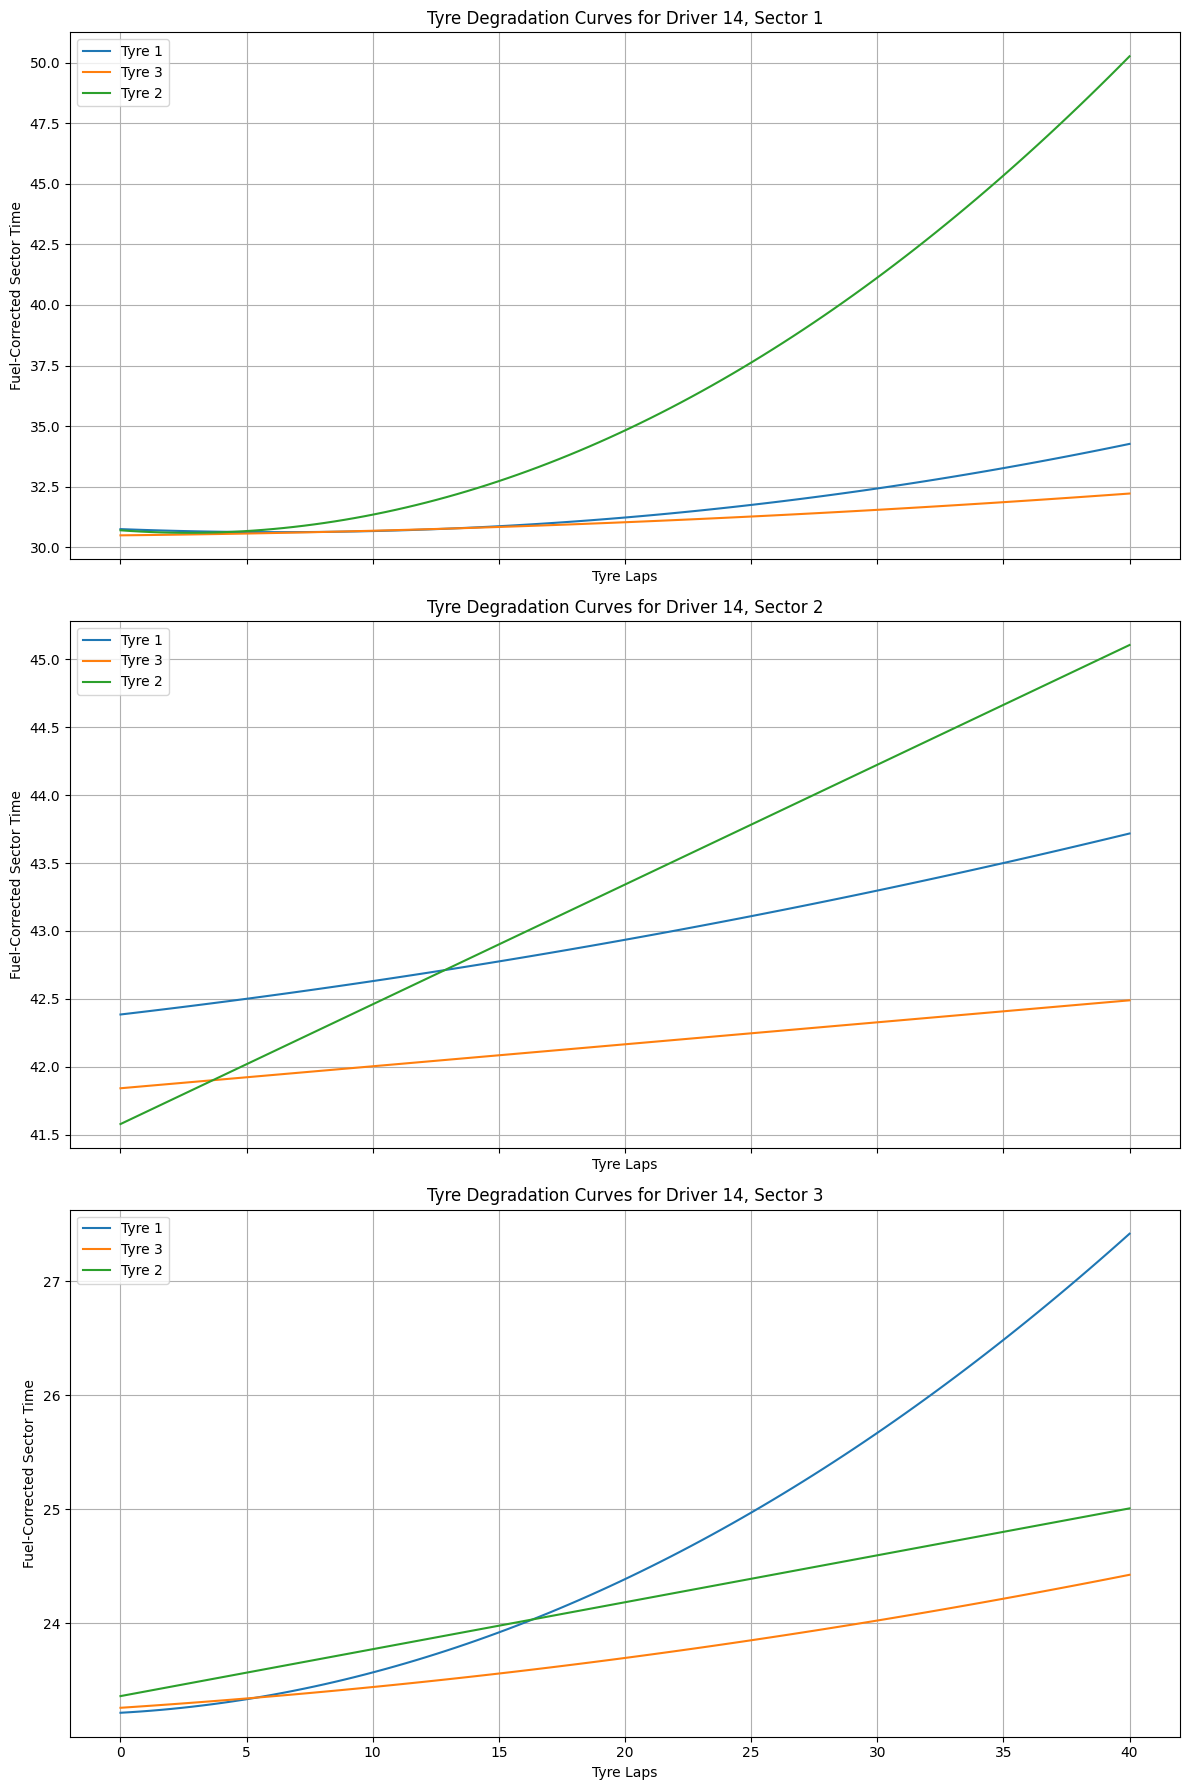

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def plot_tyre_degradation(driver_tyre_coefficients, driver_number):
    """
    Plot tyre degradation curves for a given driver, with separate plots for each sector.
    
    Parameters:
        driver_tyre_coefficients (dict): Dictionary containing tyre degradation coefficients.
        driver_number (int): The driver number for which to plot the curves.
    """
    # Check if the driver exists in the data
    if driver_number not in driver_tyre_coefficients:
        print(f"No data available for driver {driver_number}.")
        return
    
    # Get the tyre degradation coefficients for the given driver
    driver_data = driver_tyre_coefficients[driver_number]
    
    # Determine all unique sectors in the data
    all_sectors = sorted({sector for tyre_data in driver_data.values() for sector in tyre_data.keys()})
    
    # Create a figure with subplots (one for each sector)
    fig, axes = plt.subplots(len(all_sectors), 1, figsize=(12, 6 * len(all_sectors)), sharex=True)
    
    # If there's only one sector, ensure axes is iterable
    if len(all_sectors) == 1:
        axes = [axes]
    
    # Iterate over sectors and plot tyre degradation curves for each sector
    for i, sector in enumerate(all_sectors):
        ax = axes[i]
        ax.set_title(f"Tyre Degradation Curves for Driver {driver_number}, Sector {sector}")
        ax.set_xlabel("Tyre Laps")
        ax.set_ylabel("Fuel-Corrected Sector Time")
        ax.grid()
        
        # Iterate over tyre types for the current sector
        for tyre, sector_data in driver_data.items():
            if sector in sector_data:
                # Extract coefficients [a, b, c] for the polynomial ax^2 + bx + c
                a, b, c = sector_data[sector]
                
                # Generate x values (tyre laps)
                x = np.linspace(0, 40, 100)  # Assuming max tyre life of 20 laps for visualization
                
                # Compute y values (degradation curve)
                y = a * x**2 + b * x + c
                
                # Plot the curve
                ax.plot(x, y, label=f"Tyre {tyre}")
        
        # Add legend for the current sector
        ax.legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()

plot_tyre_degradation(driver_tyre_coefficients, 14)